In [1]:
using JLD2, CairoMakie, StatsBase
using Jchemo, JchemoData
using FreqTables

In [2]:
path_jdat = dirname(dirname(pathof(JchemoData)))
db = joinpath(path_jdat, "data/challenge2018.jld2")
@load db dat
pnames(dat)

(:X, :Y)

In [3]:
X = dat.X
Y = dat.Y
ntot = nro(X)

4075

In [4]:
@head X

... (4075, 680)
 


Row,1120,1122,1124,1126,1128,1130,1132,1134,1136,1138,1140,1142,1144,1146,1148,1150,1152,1154,1156,1158,1160,1162,1164,1166,1168,1170,1172,1174,1176,1178,1180,1182,1184,1186,1188,1190,1192,1194,1196,1198,1200,1202,1204,1206,1208,1210,1212,1214,1216,1218,1220,1222,1224,1226,1228,1230,1232,1234,1236,1238,1240,1242,1244,1246,1248,1250,1252,1254,1256,1258,1260,1262,1264,1266,1268,1270,1272,1274,1276,1278,1280,1282,1284,1286,1288,1290,1292,1294,1296,1298,1300,1302,1304,1306,1308,1310,1312,1314,1316,1318,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.597482,0.595978,0.593623,0.59084,0.587451,0.583092,0.578666,0.572134,0.566125,0.560204,0.551694,0.544339,0.537008,0.528312,0.520828,0.51228,0.504673,0.498204,0.48968,0.483176,0.477588,0.470384,0.464844,0.459269,0.454023,0.4496,0.444271,0.440026,0.436514,0.431822,0.428201,0.424881,0.421379,0.41859,0.415556,0.413193,0.411501,0.40946,0.408254,0.407503,0.406948,0.406903,0.407211,0.407941,0.408835,0.410495,0.412211,0.41412,0.416691,0.419178,0.421902,0.424632,0.427036,0.43022,0.432809,0.434996,0.437823,0.439963,0.442041,0.443982,0.445578,0.447395,0.448785,0.449829,0.451165,0.452131,0.453035,0.453898,0.454573,0.455325,0.455932,0.456439,0.45706,0.457588,0.458121,0.458712,0.459253,0.459968,0.460628,0.461245,0.462104,0.462849,0.463604,0.464367,0.464976,0.465614,0.466088,0.466315,0.466568,0.466553,0.466394,0.465981,0.465464,0.464522,0.463511,0.462348,0.460648,0.458807,0.456757,0.454314,⋯
2,0.954192,0.953237,0.952002,0.950426,0.948382,0.946138,0.943543,0.94057,0.937514,0.934336,0.931181,0.92803,0.924979,0.922076,0.919204,0.916252,0.913228,0.91006,0.906591,0.902934,0.899069,0.894974,0.890786,0.886513,0.882297,0.878178,0.874064,0.870132,0.866404,0.862724,0.859357,0.856211,0.853359,0.850962,0.848901,0.84742,0.846361,0.845615,0.845178,0.845054,0.845031,0.845245,0.845549,0.845977,0.846463,0.847118,0.847808,0.848598,0.849367,0.850203,0.851115,0.85195,0.852774,0.853623,0.854617,0.855511,0.856426,0.857282,0.858228,0.859145,0.860036,0.860869,0.861774,0.862626,0.863431,0.864185,0.864786,0.865254,0.865612,0.865936,0.866131,0.866294,0.8663,0.866269,0.86628,0.866326,0.866443,0.866614,0.866967,0.867366,0.867852,0.868533,0.869212,0.869894,0.870584,0.871296,0.872008,0.872612,0.873183,0.873633,0.874032,0.874337,0.87455,0.87461,0.874656,0.874554,0.87432,0.873982,0.873513,0.872882,⋯
3,0.611137,0.609566,0.60743,0.604767,0.601434,0.597316,0.592598,0.586992,0.580741,0.574189,0.566943,0.559381,0.551773,0.543753,0.535977,0.52818,0.520482,0.513455,0.506598,0.500236,0.494469,0.488922,0.483579,0.478512,0.473364,0.468619,0.463914,0.459365,0.455331,0.451357,0.447738,0.444393,0.4412,0.43831,0.435652,0.433147,0.431142,0.429417,0.428137,0.427358,0.427051,0.427196,0.427831,0.428873,0.43028,0.432035,0.434176,0.436401,0.438986,0.441528,0.444208,0.446958,0.449588,0.452339,0.455044,0.457599,0.460146,0.462568,0.464761,0.466901,0.468719,0.47045,0.472001,0.473309,0.47453,0.475624,0.476567,0.477469,0.478218,0.478939,0.479589,0.480172,0.480771,0.481325,0.48187,0.482473,0.483049,0.483702,0.484401,0.485088,0.485835,0.486543,0.487239,0.487919,0.488478,0.488971,0.489365,0.489597,0.489697,0.48958,0.489309,0.488807,0.488128,0.487165,0.485927,0.484502,0.48277,0.480747,0.47851,0.475817,⋯


In [5]:
@head Y

... (4075, 4)
 


Row,typ,label,conc,test
,String,String,Float64,Int64
1,FRG,wheat (ung),12.74,0
2,MPW,milk powder & whey,35.7212,0
3,FRG,wheat (ung),12.0,0


In [6]:
summ(Y)

(res = 4×7 DataFrame
 Row │ variable  mean    std     min          max          n      nmissing 
     │ Symbol    Union…  Union…  Any          Any          Int64  Int64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │ typ                       ANF          TTS           4075         0
   2 │ label                     animal feed  wheat (ung)   4075         0
   3 │ conc      31.93   20.348  2.766        76.604        4075         0
   4 │ test      0.092   0.289   0            1             4075         0, ntot = 4075)

In [7]:
y = Y.conc
typ = Y.typ
label = Y.label
test = Y.test
tab(test)

OrderedCollections.OrderedDict{Int64, Int64} with 2 entries:
  0 => 3701
  1 => 374

In [8]:
wl = names(X)
wl_num = parse.(Float64, wl)

680-element Vector{Float64}:
 1120.0
 1122.0
 1124.0
 1126.0
 1128.0
 1130.0
 1132.0
 1134.0
 1136.0
 1138.0
    ⋮
 2462.0
 2464.0
 2466.0
 2468.0
 2470.0
 2472.0
 2474.0
 2476.0
 2478.0

In [9]:
freqtable(string.(typ, "-", Y.label))

10-element Named Vector{Int64}
Dim1                    │ 
────────────────────────┼────
ANF-animal feed         │ 391
CLZ-rapeseed(ung)       │ 420
CNG-corn gluten         │ 395
EHH-grass silage        │ 422
FFS-full fat soya       │ 432
FRG-wheat (ung)         │ 411
MPW-milk powder & whey  │ 410
PEE-maize wp            │ 407
SFG-sun flower seed(gr) │ 281
TTS-soya meal           │ 506

In [10]:
freqtable(typ, test)

10×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │   0    1
────────────┼─────────
ANF         │ 351   40
CLZ         │ 378   42
CNG         │ 356   39
EHH         │ 380   42
FFS         │ 397   35
FRG         │ 371   40
MPW         │ 372   38
PEE         │ 367   40
SFG         │ 272    9
TTS         │ 457   49

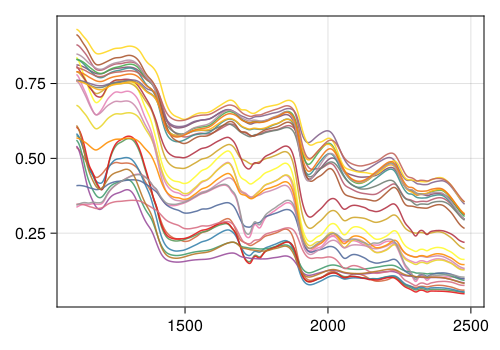

In [11]:
plotsp(X, wl_num; nsamp = 30).f

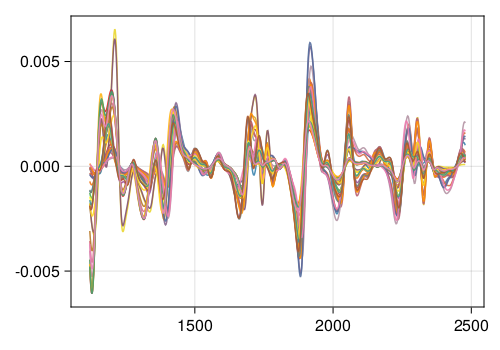

In [12]:
f = 21 ; pol = 3 ; d = 2
Xp = savgol(snv(X); f = f, pol = pol, d = d) ;

plotsp(Xp, wl_num; nsamp = 30).f

In [13]:
# Split Tot = Train + Test
# The model is tuned on Train, and
# the generalization error is estimated on Test.
# Here the split of Tot is provided by the dataset
# (= variable 'test'), but Tot could be split
# a posteriori (e.g. random sampling, systematic
# sampling, etc.)
s = Bool.(test)
Xtrain = rmrow(Xp, s)
ytrain = rmrow(y, s)
Xtest = Xp[s, :]
ytest = y[s]
ntrain = nro(Xtrain)
ntest = nro(Xtest)
(ntot = ntot, ntrain, ntest)

(ntot = 4075, ntrain = 3701, ntest = 374)

In [14]:
# Build the split Train = Cal + Val
# The model will be fitted on cal and
# optimized on Val
nval = 300
# Or:
#pct = .20
#nval = Int64(round(pct * ntrain))

300

In [15]:
# Different methods can be used to select Val
# (1) Random sampling
s = sample(1:ntrain, nval; replace = false)

# (2) Or Kennard-Stone sampling
# Output 'train' contains higher variability
# than output 'test'
#res = sampks(Xtrain; k = nval)
#s = res.train

# (3) Or duplex sampling
#res = sampdp(Xtrain; k = nval)
#s = res.train

# (4) Or systematic sampling over y
#res = sampsys(ytrain; k = nval)
#s = res.train

300-element Vector{Int64}:
 3447
 1966
  318
 1791
 3528
 3627
 1427
 1688
  993
 2044
    ⋮
 2473
  231
 2615
 1957
 1261
 1999
 1503
 3311
 1280

In [16]:
Xcal = rmrow(Xtrain, s)
ycal = rmrow(ytrain, s)
Xval = Xtrain[s, :]
yval = ytrain[s, :]
ncal = ntrain - nval
(ntot = ntot, ntrain, ntest, ncal, nval)

(ntot = 4075, ntrain = 3701, ntest = 374, ncal = 3401, nval = 300)

In [17]:
# Model tuning
nlv = 0:50
res = gridscorelv(Xcal, ycal, Xval, yval;
    score = rmsep, fun = plskern, nlv = nlv)

Row,nlv,y1
,Int64,Float64
1,0,20.7198
2,1,9.09311
3,2,5.51806
4,3,4.19323
5,4,4.03088
6,5,3.80819
7,6,3.186
8,7,2.85776
9,8,2.42659


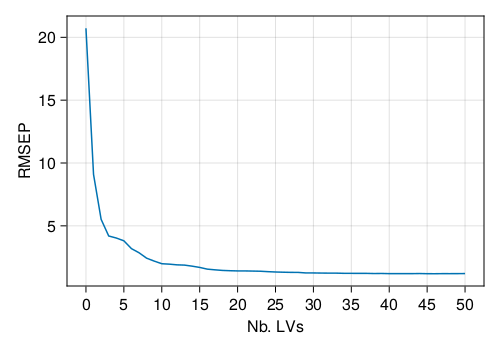

In [18]:
plotgrid(res.nlv, res.y1; step = 5,
    xlabel = "Nb. LVs", ylabel = "RMSEP").f

In [19]:
# Find the minimal prediction error
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,nlv,y1
,Int64,Float64
47,46,1.1897


In [20]:
# Final prediction (Test) using the optimal model
fm = plskern(Xtrain, ytrain; nlv = res.nlv[u]) ;
pred = Jchemo.predict(fm, Xtest).pred

374×1 Matrix{Float64}:
 18.371468468148798
  5.813814660635302
 12.255589631038138
 53.71087916065861
 26.58395450142463
 54.152820477160724
 38.054049118536625
 19.759198135579403
  9.759511684893916
 19.613531546359113
  ⋮
 66.00430059767253
 54.859538934333486
 51.557984772933025
  8.860070181970876
 12.198957614129032
 12.702699132203094
 20.002429944778527
 67.99833141077038
 24.380665073948478

In [21]:
# Generalization error
rmsep(pred, ytest)

1×1 Matrix{Float64}:
 1.1605941808672706

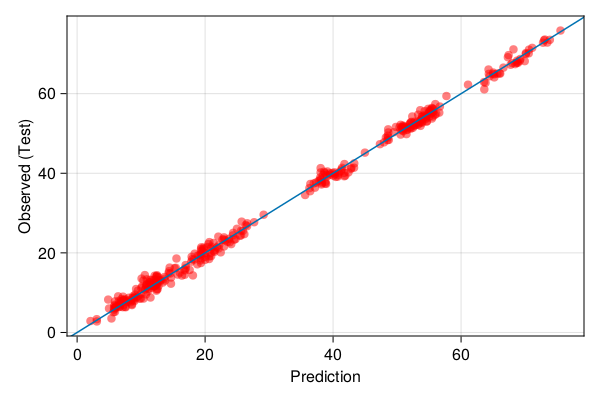

In [22]:
# Plotting predictions vs. observed data
plotxy(vec(pred), ytest; color = (:red, .5),
    bisect = true, xlabel = "Prediction",
    ylabel = "Observed (Test)").f

In [23]:
# A parcimony approach
# Wold's criterion
res_sel = selwold(res.nlv, res.y1; smooth = true,
    alpha = .025, f = 10, step = 5, graph = true) ;
pnames(res)

2-element Vector{Symbol}:
 :nlv
 :y1

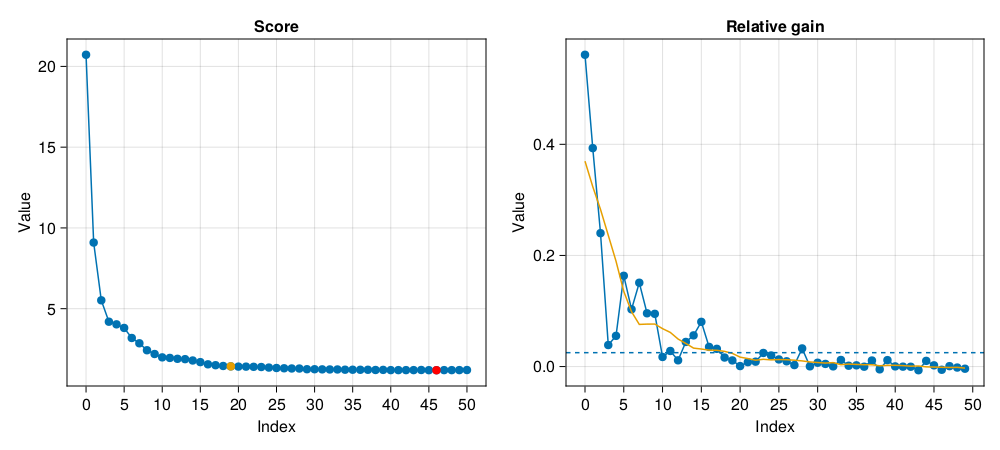

In [24]:
res_sel.f       # plots

In [25]:
res_sel.opt     # nb. LVs correponding to the minimal error rate

46

In [26]:
res_sel.sel     # nb. LVs selected with the Wold's criterion

19

In [27]:
# Final prediction with the parcimonious model
fm = plskern(Xtrain, ytrain; nlv = res_sel.sel) ;
pred = Jchemo.predict(fm, Xtest).pred
@show rmsep(pred, ytest)

rmsep(pred, ytest) = [1.3619545979326824;;]


1×1 Matrix{Float64}:
 1.3619545979326824

In [28]:
# !!! Remark
# Function "gridscore" is generic for all the functions.
# Here, it could be used instead of "gridscorelv"
# but this is not time-efficient for LV-based methods.
# Commands below return the same results as
# with 'gridscorelv', but in a slower way
nlv = 0:50
pars = mpar(nlv = nlv)
res = gridscore(Xcal, ycal, Xval, yval;
    score = rmsep, fun = plskern, pars = pars)
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,nlv,y1
,Int64,Float64
47,46,1.1897


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*